In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Importing the raw data file
retail = pd.read_csv("Online Retail.csv", dtype={'InvoiceNo': str})

In [10]:
# First glance at the data
print(retail.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [11]:
# CANCELLATIONS
# Filter out cancellations
cancellation_count = retail[retail['InvoiceNo'].str.contains('C')]['InvoiceNo'].count()
print("Total cancellations:", cancellation_count)

Total cancellations: 9288


In [12]:
# Remove cancellations
retail = retail[~retail['InvoiceNo'].str.contains('C')]
retail.shape[0]

532621

In [13]:
# NEGATIVE QUANTITIES
# Filter out rows with non-positive Quantity
print(retail[retail['Quantity'] <= 0].groupby(['Description', 'UnitPrice']).size().nlargest(10))

Description             UnitPrice
check                   0.0          120
damages                 0.0           45
damaged                 0.0           42
?                       0.0           41
sold as set on dotcom   0.0           20
Damaged                 0.0           14
Unsaleable, destroyed.  0.0            9
thrown away             0.0            9
??                      0.0            7
damages?                0.0            5
dtype: int64


In [14]:
# Remove rows with non-positive Quantity
retail = retail[retail['Quantity'] > 0]
retail.shape[0]

531285

In [15]:
# NON-PRODUCT STOCKCODES
stc = ['AMAZONFEE', 'BANK CHARGES', 'C2', 'DCGSSBOY', 'DCGSSGIRL', 'DOT', 'gift_0001_', 'PADS', 'POST']

In [16]:
# Filling NaN values in 'StockCode' column with an empty string
retail['StockCode'].fillna('', inplace=True)

# Convert 'StockCode' column to string type
retail['StockCode'] = retail['StockCode'].astype(str)

# Applying mask after filling NaN values
filtered_data = retail[retail['StockCode'].str.contains('|'.join(stc))].groupby(['StockCode', 'Description']).size().nlargest(10)
print(filtered_data)

StockCode     Description                       
POST          POSTAGE                               1126
DOT           DOTCOM POSTAGE                         708
C2            CARRIAGE                               141
DCGSSGIRL     GIRLS PARTY BAG                         13
BANK CHARGES  Bank Charges                            12
DCGSSBOY      BOYS PARTY BAG                          11
gift_0001_20  Dotcomgiftshop Gift Voucher £20.00       9
gift_0001_10  Dotcomgiftshop Gift Voucher £10.00       8
gift_0001_30  Dotcomgiftshop Gift Voucher £30.00       7
PADS          PADS TO MATCH ALL CUSHIONS               4
dtype: int64


In [17]:
# Remove non-product related rows
retail = retail[~retail['StockCode'].str.contains('|'.join(stc))]
retail.shape[0]

529228

In [18]:
# DESCRIPTION
descr = ["check", "check?", "?", "??", "damaged", "found", "adjustment", "Amazon", "AMAZON", "amazon adjust",
         "Amazon Adjustment", "amazon sales", "Found", "FOUND", "found box", "Found by jackie ", "Found in w/hse",
         "dotcom", "dotcom adjust", "allocate stock for dotcom orders ta", "FBA", "Dotcomgiftshop Gift Voucher £100.00",
         "on cargo order", "wrongly sold (22719) barcode", "wrongly marked 23343", "dotcomstock",
         "rcvd be air temp fix for dotcom sit", "Manual", "John Lewis", "had been put aside", "for online retail orders",
         "taig adjust", "amazon", "incorrectly credited C550456 see 47", "returned", "wrongly coded 20713",
         "came coded as 20713", "add stock to allocate online orders", "Adjust bad debt",
         "alan hodge cant mamage this section", "website fixed", "did a credit  and did not tick ret", "michel oops",
         "incorrectly credited C550456 see 47", "mailout", "test", "Sale error", "Lighthouse Trading zero invc incorr",
         "SAMPLES", "Marked as 23343", "wrongly coded 23343", "Adjustment", "rcvd be air temp fix for dotcom sit",
         "Had been put aside."]
print(retail[retail['Description'].isin(descr)].groupby('Description').size())

Description
?                                        6
AMAZON                                   3
Adjust bad debt                          3
Adjustment                               2
Amazon                                   7
Amazon Adjustment                        1
Dotcomgiftshop Gift Voucher £100.00      1
FBA                                      1
FOUND                                    1
Found                                    8
Found in w/hse                           1
Had been put aside.                      1
John Lewis                               1
Lighthouse Trading zero invc incorr      1
Manual                                 328
Marked as 23343                          1
SAMPLES                                  2
Sale error                               1
add stock to allocate online orders      1
adjustment                              14
alan hodge cant mamage this section      1
allocate stock for dotcom orders ta      1
amazon                                   8

In [19]:
# Remove unwanted entries in Description
retail = retail[~retail['Description'].isin(descr)]

# Remove rows with NA in Description
retail = retail.dropna(subset=['Description'])
retail.shape[0]

528150

In [20]:
# CUSTOMER ID
print(retail['CustomerID'].value_counts(dropna=False))

NaN        131780
17841.0      7838
14911.0      5591
14096.0      5095
12748.0      4580
            ...  
14705.0         1
13841.0         1
17715.0         1
18084.0         1
13099.0         1
Name: CustomerID, Length: 4336, dtype: int64


In [21]:
# FINAL TOUCHES
retail['InvoiceNo'] = pd.to_numeric(retail['InvoiceNo'])
retail['Date'] = pd.to_datetime(retail['InvoiceDate']).dt.date
retail['Time'] = pd.to_datetime(retail['InvoiceDate']).dt.strftime('%H:%M:%S')

In [22]:
# Saving cleansed data for analysis phase
retail.to_pickle("retail.pkl")

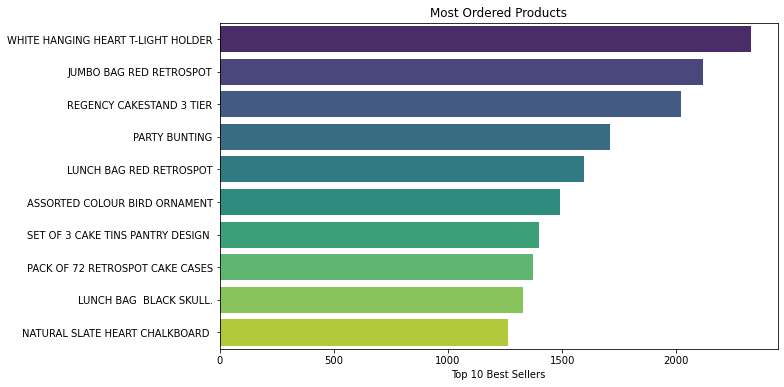

In [23]:
# EXPLORATORY DATA ANALYSIS

# What items do people buy more often?
top_sellers = retail['Description'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_sellers.index, x=top_sellers.values, palette='viridis')
plt.xlabel('Top 10 Best Sellers')
plt.ylabel('')
plt.title('Most Ordered Products')
plt.show()

In [24]:
# Top 10 most sold products represent around 3% of total items sold by the company
pct_top_sellers = (retail['Description'].value_counts() / len(retail) * 100).nlargest(10)
print(pct_top_sellers)


WHITE HANGING HEART T-LIGHT HOLDER    0.440595
JUMBO BAG RED RETROSPOT               0.400454
REGENCY CAKESTAND 3 TIER              0.382278
PARTY BUNTING                         0.323204
LUNCH BAG RED RETROSPOT               0.301808
ASSORTED COLOUR BIRD ORNAMENT         0.281927
SET OF 3 CAKE TINS PANTRY DESIGN      0.264887
PACK OF 72 RETROSPOT CAKE CASES       0.259396
LUNCH BAG  BLACK SKULL.               0.251444
NATURAL SLATE HEART CHALKBOARD        0.239137
Name: Description, dtype: float64


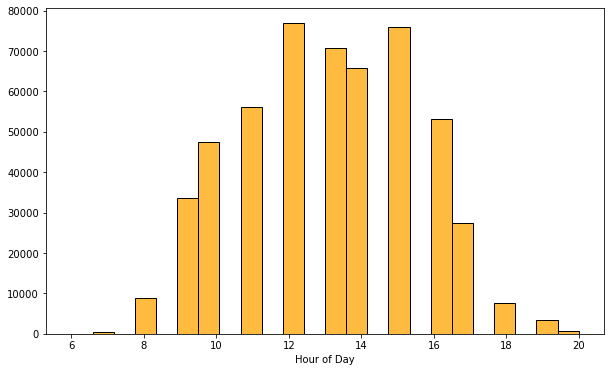

In [25]:
# What time of day do people buy more often?
retail['Time'] = pd.to_datetime(retail['Time'])
plt.figure(figsize=(10, 6))
sns.histplot(retail['Time'].dt.hour, bins=24, kde=False, color='orange')
plt.xlabel('Hour of Day')
plt.ylabel('')
plt.show()


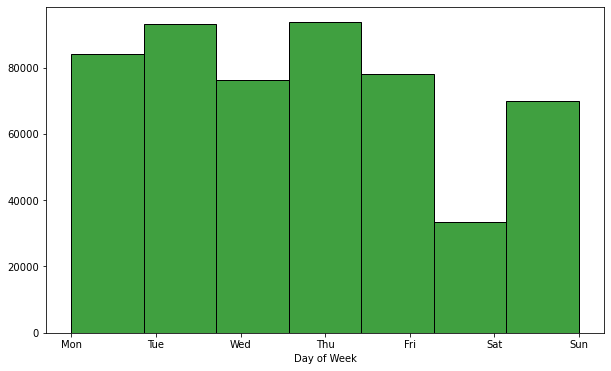

In [26]:
# What day of the week do people buy more often?

# Assuming 'Date' column is not datetime-like, convert it to datetime
retail['Date'] = pd.to_datetime(retail['Date'])

# Plotting histogram of day of week
plt.figure(figsize=(10, 6))
sns.histplot(retail['Date'].dt.dayofweek, bins=7, kde=False, color='green')
plt.xlabel('Day of Week')
plt.ylabel('')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()



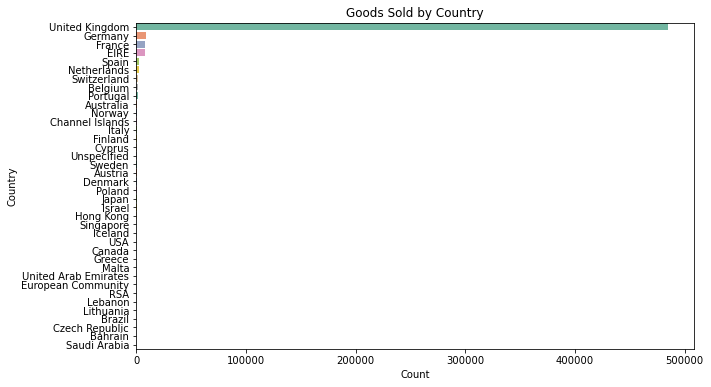

In [27]:
# Which countries do they sell their goods to?
plt.figure(figsize=(10, 6))
sns.countplot(y=retail['Country'], order=retail['Country'].value_counts().index, palette='Set2')
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Goods Sold by Country')
plt.show()

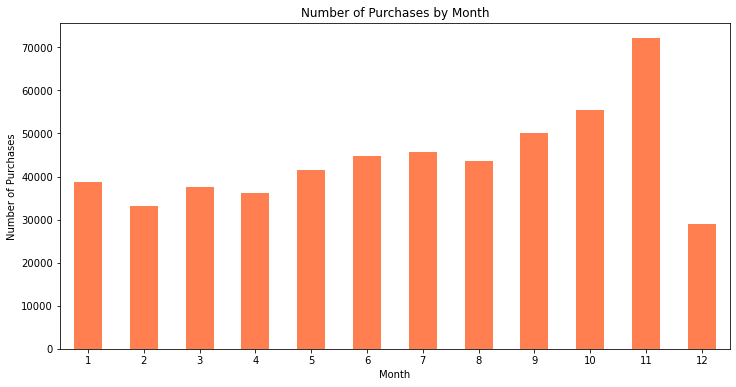

In [28]:
# Convert 'InvoiceDate' to datetime if it's not already in datetime format
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

# Calculate number of purchases per month
sales_by_month = retail.groupby(retail['InvoiceDate'].dt.month).size()
 
# Plotting
plt.figure(figsize=(12, 6))
sales_by_month.plot(kind='bar', color='coral')
 
# Adding labels and title
plt.title('Number of Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
 
# Rotate x-axis labels for better readability
plt.xticks(rotation=0)
 
# Show the plot
plt.show()


In [29]:
# Check and convert InvoiceDate to datetime if needed
if not pd.api.types.is_datetime64_dtype(retail['InvoiceDate']):
    retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
 
# Select rows where month is November or January
nov_jan_data = retail.loc[(retail['InvoiceDate'].dt.month == 11) | (retail['InvoiceDate'].dt.month == 1), :]
 
# Calculate average order value
average_order_value = (nov_jan_data['Quantity'] * nov_jan_data['UnitPrice']).mean()
 
# Print the result
print(f"Average Order Value during November and January: {average_order_value:.2f}")

Average Order Value during November and January: 18.27


In [30]:
# Filtering by an order number which contains the same stock code more than once
# to show duplicate items within the same order
duplicate_items = retail[(retail['InvoiceNo'] == '557886') & (retail['StockCode'] == '22436')]
print(duplicate_items[['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'CustomerID']])

Empty DataFrame
Columns: [InvoiceNo, StockCode, Quantity, UnitPrice, CustomerID]
Index: []


In [31]:
# Removing duplicates

# Convert 'InvoiceNo' column to string type
retail['InvoiceNo'] = retail['InvoiceNo'].astype(str)

# Concatenate 'InvoiceNo' and 'Description' columns
retail['InNo_Desc'] = retail['InvoiceNo'] + ' ' + retail['Description']

# Remove duplicates based on the concatenated column
retail = retail[~retail['InNo_Desc'].duplicated(keep='first')]


In [32]:
print("Total row count after removing duplicates:", len(retail))

Total row count after removing duplicates: 517465


# Based on Association Rule Technique

In [206]:
from mlxtend.frequent_patterns import apriori, association_rules

In [207]:
def encode(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [208]:
def RecommendItems_Association(CurItemOfInterest, CustomerID, Country, Date = None, Time = None):
    # Filtering the dataset by country
    filtered_trans = (retail[retail['Country'] == Country]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

    # Encoding the Data
    trans_encoded = filtered_trans.applymap(encode)

    # Filtering by Current Item Of Interest
    transactions = trans_encoded.loc[trans_encoded[CurItemOfInterest] == 1]

    # Using apriori algorithm for association rule mining in transactional dataset
    frequent_items = apriori(transactions, min_support=0.05, use_colnames=True)

    # Storing inferred rules in dataframe
    rules = association_rules(frequent_items, metric="lift", min_threshold=3)
    rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

    # Filtering out the current item of interest from recommendations
    recommendations = rules['consequents'].apply(lambda x: x.difference({CurItemOfInterest})).unique()[:10]

    return recommendations


In [209]:
recommended_items = RecommendItems_Association('WHITE METAL LANTERN', 'pass', 'United Kingdom')
print(recommended_items)

C:\Users\Ruchika Gupta\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


[frozenset({'RETRO COFFEE MUGS ASSORTED', 'WOODEN FRAME ANTIQUE WHITE '})
 frozenset({'WOODEN PICTURE FRAME WHITE FINISH', 'GLASS STAR FROSTED T-LIGHT HOLDER', 'CREAM CUPID HEARTS COAT HANGER'})
 frozenset({'RETRO COFFEE MUGS ASSORTED', 'WOODEN FRAME ANTIQUE WHITE ', 'WHITE HANGING HEART T-LIGHT HOLDER'})
 frozenset({'WOODEN PICTURE FRAME WHITE FINISH', 'GLASS STAR FROSTED T-LIGHT HOLDER', 'CREAM CUPID HEARTS COAT HANGER', 'WHITE HANGING HEART T-LIGHT HOLDER'})
 frozenset({'WOODEN PICTURE FRAME WHITE FINISH', 'RETRO COFFEE MUGS ASSORTED'})
 frozenset({'WOODEN PICTURE FRAME WHITE FINISH', 'CREAM CUPID HEARTS COAT HANGER', 'WHITE HANGING HEART T-LIGHT HOLDER'})
 frozenset({'RETRO COFFEE MUGS ASSORTED', 'GLASS STAR FROSTED T-LIGHT HOLDER', 'KNITTED UNION FLAG HOT WATER BOTTLE'})
 frozenset({'RETRO COFFEE MUGS ASSORTED', 'GLASS STAR FROSTED T-LIGHT HOLDER', 'RED WOOLLY HOTTIE WHITE HEART.'})
 frozenset({'GLASS STAR FROSTED T-LIGHT HOLDER', 'VINTAGE BILLBOARD DRINK ME MUG', 'RED WOOLLY HOTT

# Popular Item approach

In [210]:
def get_frequent_items(retail, min_support):
    
    grouped_transactions = retail.groupby('InvoiceNo')['Description'].apply(list)
    
    transactions = grouped_transactions.tolist()
    
    item_counts = {}
    for transaction in transactions:
        for item in transaction:
            if item in item_counts:
                item_counts[item] += 1
            else:
                item_counts[item] = 1
                
    min_count = min_support * len(transactions)
    
    frequent_items = []

    for item, count in item_counts.items():
        if count >= min_count:
            frequent_items.append(item)
            
    return frequent_items

In [211]:
frequent_items = get_frequent_items(retail, 0.05)
l = len(frequent_items)
print(l)
frequent_items

33


['WHITE HANGING HEART T-LIGHT HOLDER',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'JAM MAKING SET WITH JARS',
 'ALARM CLOCK BAKELIKE RED ',
 "PAPER CHAIN KIT 50'S CHRISTMAS ",
 'WOODEN PICTURE FRAME WHITE FINISH',
 'JUMBO BAG PINK POLKADOT',
 'LUNCH BAG RED RETROSPOT',
 'PACK OF 72 RETROSPOT CAKE CASES',
 'JUMBO STORAGE BAG SUKI',
 'JAM MAKING SET PRINTED',
 'JUMBO SHOPPER VINTAGE RED PAISLEY',
 'NATURAL SLATE HEART CHALKBOARD ',
 'HEART OF WICKER SMALL',
 'JUMBO BAG RED RETROSPOT',
 'LUNCH BAG SPACEBOY DESIGN ',
 'LUNCH BAG WOODLAND',
 'LUNCH BAG PINK POLKADOT',
 'LUNCH BAG CARS BLUE',
 'LUNCH BAG  BLACK SKULL.',
 'VICTORIAN GLASS HANGING T-LIGHT',
 'REGENCY CAKESTAND 3 TIER',
 'ROSES REGENCY TEACUP AND SAUCER ',
 'GREEN REGENCY TEACUP AND SAUCER',
 'RECIPE BOX PANTRY YELLOW DESIGN',
 'RED RETROSPOT CHARLOTTE BAG',
 'PARTY BUNTING',
 'SET OF 3 CAKE TINS PANTRY DESIGN ',
 'SET OF 4 PANTRY JELLY MOULDS',
 'LUNCH BAG SUKI DESIGN ',
 'LUNCH BAG APPLE DESIGN',
 'SPOTTY BUNTING',
 'RABBIT NIGHT LIG

In [212]:
def RecommendItems_Popular(curr_item_of_interest, retail, CustomerID = None, Country = None, Time = None, Date = None):
    
    grouped_transactions = retail.groupby('InvoiceNo')['Description'].apply(list)
    
    transactions = grouped_transactions.tolist()
    
    co_occurring_items = {}
    
    valid_transactions = []
    for t in transactions:
        if curr_item_of_interest in t:
            valid_transactions.append(t)
            
    print(len(valid_transactions))
    
    for transaction in valid_transactions:
        for item in transaction:
            if item != curr_item_of_interest and item in frequent_items:
                if item in co_occurring_items:
                    co_occurring_items[item] +=1
                else:
                    co_occurring_items[item] = 1
                    
    recommended_items = sorted(co_occurring_items, key=lambda item: item[1], reverse = True)
    
    return recommended_items
                  

In [213]:
curr_item_of_interest = 'PARTY BUNTING'
recommended_items = RecommendItems_Popular(curr_item_of_interest, retail)
recommended_items

1686


['LUNCH BAG RED RETROSPOT',
 'JUMBO BAG RED RETROSPOT',
 'JUMBO BAG PINK POLKADOT',
 'LUNCH BAG SPACEBOY DESIGN ',
 'LUNCH BAG PINK POLKADOT',
 'LUNCH BAG WOODLAND',
 'LUNCH BAG  BLACK SKULL.',
 'JUMBO STORAGE BAG SUKI',
 'LUNCH BAG CARS BLUE',
 'JUMBO SHOPPER VINTAGE RED PAISLEY',
 'LUNCH BAG SUKI DESIGN ',
 'LUNCH BAG APPLE DESIGN',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'GREEN REGENCY TEACUP AND SAUCER',
 'SPOTTY BUNTING',
 'ROSES REGENCY TEACUP AND SAUCER ',
 'WOODEN PICTURE FRAME WHITE FINISH',
 'ALARM CLOCK BAKELIKE RED ',
 'VICTORIAN GLASS HANGING T-LIGHT',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'RED RETROSPOT CHARLOTTE BAG',
 'HEART OF WICKER SMALL',
 'RECIPE BOX PANTRY YELLOW DESIGN',
 'REGENCY CAKESTAND 3 TIER',
 'SET OF 3 CAKE TINS PANTRY DESIGN ',
 'SET OF 4 PANTRY JELLY MOULDS',
 'NATURAL SLATE HEART CHALKBOARD ',
 'JAM MAKING SET WITH JARS',
 "PAPER CHAIN KIT 50'S CHRISTMAS ",
 'JAM MAKING SET PRINTED',
 'PACK OF 72 RETROSPOT CAKE CASES',
 'RABBIT NIGHT LIGHT']

# User-based Collaborative Filtering Technique

In [33]:
def jaccard_similarity(set1, set2):
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union != 0:
        similarity_score = intersection/union
    else:
        0
    return similarity_score

In [34]:
def RecommendItems_collaborative(retail, CustomerID, top_n=10):
    
    grouped_transactions = retail.groupby('CustomerID')['Description'].apply(list)
    
    transactions_dict = grouped_transactions.to_dict()
    
#     print(len(transactions_dict))
    
    customer_similarity_pairs = {}

    key_values = list(transactions_dict.items())

    for i, (key1, value1) in enumerate(key_values):
        for j, (key2, value2) in enumerate(key_values):
            if i !=j:
                value1 = tuple(value1)
                value2 = tuple(value2)
                if (value1, value2) not in customer_similarity_pairs and (value2, value1) not in customer_similarity_pairs:
                    set1 = set(value1)
                    set2 = set(value2)
                    similarity_score = jaccard_similarity(set1, set2)
                    customer_similarity_pairs[(key1, key2)] = similarity_score
    # Get the list of items purchased by the customer
    preferences = set(transactions_dict.get(CustomerID, []))
    
    # Initialize a dictionary to store recommendations
    recommendations = {}
    
    # Iterate over similarity pairs
    for (customer1, customer2), similarity_score in customer_similarity_pairs.items():
        # Check if customer2's items are not in customer1's preferences
        if customer1 == CustomerID and customer2 != CustomerID:
            for item in transactions_dict.get(customer2, []):
                if item not in preferences:
                    # Add similarity score to recommendations
                    recommendations[item] = recommendations.get(item, 0) + similarity_score
    
    # Sort recommendations by similarity score
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    recommended_items = [item[0] for item in sorted_recommendations[:top_n]]
    
    # Return top n recommendations
    return recommended_items

In [ ]:
# Example usage:
customer_id = 17850  # Example customer ID
recommended_items = RecommendItems(retail, customer_id)
print(recommended_items)

In [35]:
def RecommendItems(CurItemOfInterest, CustomerID, Country, Time, Date):
    
    return RecommendItems_collaborative(retail, CustomerID)

In [36]:
# Example usage:
recommended_items = RecommendItems("JUMBO BAG RED RETROSPOT", 17850, "United Kingdom", "08:26:00", "01-12-2010" )
print(recommended_items)

['REGENCY CAKESTAND 3 TIER', 'JUMBO BAG RED RETROSPOT', 'ASSORTED COLOUR BIRD ORNAMENT', 'PARTY BUNTING', 'HEART OF WICKER SMALL', 'LUNCH BAG RED RETROSPOT', 'HEART OF WICKER LARGE', 'NATURAL SLATE HEART CHALKBOARD ', 'WOOD BLACK BOARD ANT WHITE FINISH', 'SET OF 3 CAKE TINS PANTRY DESIGN ']


In [37]:
RecommendItems("JUMBO BAG RED RETROSPOT", 17850, "United Kingdom", "08:26:00", "01-12-2010" )

['REGENCY CAKESTAND 3 TIER',
 'JUMBO BAG RED RETROSPOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'PARTY BUNTING',
 'HEART OF WICKER SMALL',
 'LUNCH BAG RED RETROSPOT',
 'HEART OF WICKER LARGE',
 'NATURAL SLATE HEART CHALKBOARD ',
 'WOOD BLACK BOARD ANT WHITE FINISH',
 'SET OF 3 CAKE TINS PANTRY DESIGN ']